In [1]:
print("Hello")

Hello


Import numpy and its concrete version

In [2]:
import concrete.numpy as cnp
import numpy as np

Formulate the logistic regression model that is given in the paper

In [3]:
#Weights and bias of the model
# age, systolic blood pressure, diastolic blood pressure, cholesterol level, height (inches), weight (pounds)
weights = np.array([0.072, 0.013, -0.029, 0.008, -0.053, 0.021])
bias = np.array([0])

def sigmoid(x):
    #e^x / (e^x+1)
    return 1 / (1 + np.exp(-x))

def L(data):
    return sigmoid(np.dot(data, weights) + bias)



Test the model with an example, we should obtain a probabilty between 0 and 1
(Examples taken from [LRM] of the paper: http://www.claudiaflowers.net/rsch8140/logistic_regression_example.htm)

In [4]:
#person1_data = np.array([64.0, 105.0, 68.0, 261.0, 66.0, 108.0])
person1_data = np.array([64, 105, 68, 261, 66, 108])
print(L(person1_data))

#person2_data = np.array([50.0, 160.0, 110.0, 261.0, 66.0, 145.0])
person2_data = np.array([50, 160, 110, 261, 66, 145])
print(L(person2_data))

[0.99230149]
[0.98409361]


Now try and do the whole thing encrypted with FHE
I follow the concrete-numpy documentation on compiling numpy functions
https://docs.zama.ai/concrete-numpy/stable/user/basics/compiling_and_executing.html?highlight=compile_numpy_function

In [5]:
#declare that the input variable x is encrypted (and of what shape?)
data_type = "encrypted"

#give an inputset of example inputs to determine the input bounds
#for us, inputs in the range [-3.755, 2.403] are allowed
#TODO (what is better, give min and max as only input examples or give several inputs inbetween?)
#TODO I think I need to give some range on the data input, i.e. age and so on, not the linear combination of data and weights
inputset = [np.array([64, 105, 68, 261, 66, 108]), np.array([50, 160, 110, 261, 66, 145])]
#inputset = [50, 261]

#compile the function to its homomorphic equivalent
compiler = cnp.NPFHECompiler(
    L, {"data": data_type},
)
circuit = compiler.compile_on_inputset(inputset)

RuntimeError: function you are trying to compile isn't supported for MLIR lowering

 %0 = 1                                # ClearScalar<uint1>
 %1 = 1                                # ClearScalar<uint1>
 %2 = 0                                # ClearScalar<uint1>
 %3 = [0]                              # ClearTensor<uint1, shape=(1,)>
 %4 = data                             # EncryptedTensor<uint9, shape=(6,)>
 %5 = [ 0.072  0 ... 53  0.021]        # ClearTensor<float64, shape=(6,)>
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^ only integer constants are supported
 %6 = dot(%4, %5)                      # EncryptedScalar<float64>
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^ only integer dot product is supported
 %7 = add(%6, %3)                      # EncryptedTensor<float64, shape=(1,)>
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^ only integer addition is supported
 %8 = sub(%2, %7)                      # EncryptedTensor<float64, shape=(1,)>
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^ only integer subtraction is supported
 %9 = exp(%8)                          # EncryptedTensor<float64, shape=(1,)>
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^ exp with floating-point inputs is required to be fused to be supported
%10 = add(%9, %1)                      # EncryptedTensor<float64, shape=(1,)>
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^ only integer addition is supported
%11 = truediv(%0, %10)                 # EncryptedTensor<float64, shape=(1,)>
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^ truediv with floating-point inputs is required to be fused to be supported
return %11

!!! Big issue: floating point functions can be compiled but only univariate ones since that's what works with the lookup table
see Limitations of: https://docs.zama.ai/concrete-numpy/stable/user/tutorial/working_with_floating_points.html

In [6]:
print(str(compiler))

 %0 = 1                                # ClearScalar<uint1>
 %1 = 1                                # ClearScalar<uint1>
 %2 = 0                                # ClearScalar<uint1>
 %3 = [0]                              # ClearTensor<uint1, shape=(1,)>
 %4 = data                             # EncryptedTensor<uint9, shape=(6,)>
 %5 = [ 0.072  0 ... 53  0.021]        # ClearTensor<float64, shape=(6,)>
 %6 = dot(%4, %5)                      # EncryptedScalar<float64>
 %7 = add(%6, %3)                      # EncryptedTensor<float64, shape=(1,)>
 %8 = sub(%2, %7)                      # EncryptedTensor<float64, shape=(1,)>
 %9 = exp(%8)                          # EncryptedTensor<float64, shape=(1,)>
%10 = add(%9, %1)                      # EncryptedTensor<float64, shape=(1,)>
%11 = truediv(%0, %10)                 # EncryptedTensor<float64, shape=(1,)>
return %11


Now we try to do homomorphic evaluation

In [7]:
circuit.encrypt_run_decrypt(np.array([64, 105, 68, 261, 66, 108]))

NameError: name 'circuit' is not defined

Try and obtain the linear combination x via a separate function
This first attempt still doesn't work since we multiply by constants but they're floating points

In [8]:
def val_from_data(data):
    return np.dot(data, weights) + bias

compiler2 = cnp.NPFHECompiler(
    val_from_data, {"data": data_type},
)
circuit2 = compiler2.compile_on_inputset(inputset)

RuntimeError: function you are trying to compile isn't supported for MLIR lowering

%0 = [0]                              # ClearTensor<uint1, shape=(1,)>
%1 = data                             # EncryptedTensor<uint9, shape=(6,)>
%2 = [ 0.072  0 ... 53  0.021]        # ClearTensor<float64, shape=(6,)>
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^ only integer constants are supported
%3 = dot(%1, %2)                      # EncryptedScalar<float64>
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^ only integer dot product is supported
%4 = add(%3, %0)                      # EncryptedTensor<float64, shape=(1,)>
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^ only integer addition is supported
return %4

Next ideas:
input data should be integers so only problem is the weights, we can scale them and then reduce them again to obtain the single
floating point as input, then we should be able to evaluate the model homomorphically.

In [9]:
adjusted_weights = np.array([round(w * 1000) for w in weights])
print(adjusted_weights)

def val_from_data_adjusted(data):
    return np.dot(data, adjusted_weights) + bias

compiler3 = cnp.NPFHECompiler(
    val_from_data_adjusted, {"data": data_type},
)
circuit3 = compiler3.compile_on_inputset(inputset)

[ 72  13 -29   8 -53  21]


RuntimeError: max_bit_width of some nodes is too high for the current version of the compiler (maximum must be 8) which is not compatible with:

%0 = [0]                              # ClearTensor<uint1, shape=(1,)>
%1 = data                             # EncryptedTensor<uint9, shape=(6,)>
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^ 9 bits is not supported for the time being
%2 = [ 72  13 -29   8 -53  21]        # ClearTensor<int8, shape=(6,)>
%3 = dot(%1, %2)                      # EncryptedScalar<uint13>
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^ 13 bits is not supported for the time being
%4 = add(%3, %0)                      # EncryptedTensor<uint13, shape=(1,)>
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^ 13 bits is not supported for the time being
return %4

Latest error: bit_width of the input is not supported, I guess too large integers
I don't quite know why, the ints fit in a 128 wide range, i.e. 72+53 = 125 should not pose a problem
Maybe it is because it's an array or maybe we could shift the integers to actually be in 0 to 127, though that requires more pre- and post-computation, additionally to the scaling.

In [12]:
test_weights = np.array([1, 1, 1, 1, 1, 1])
print(test_weights)

def val_from_data_test(data):
    return np.dot(data, test_weights) + bias

compiler4 = cnp.NPFHECompiler(
    val_from_data_test, {"data": data_type},
)
circuit4 = compiler4.compile_on_inputset(inputset)

[1 1 1 1 1 1]


RuntimeError: max_bit_width of some nodes is too high for the current version of the compiler (maximum must be 8) which is not compatible with:

%0 = [0]                  # ClearTensor<uint1, shape=(1,)>
%1 = data                 # EncryptedTensor<uint9, shape=(6,)>
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^ 9 bits is not supported for the time being
%2 = [1 1 1 1 1 1]        # ClearTensor<uint1, shape=(6,)>
%3 = dot(%1, %2)          # EncryptedScalar<uint10>
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^ 10 bits is not supported for the time being
%4 = add(%3, %0)          # EncryptedTensor<uint10, shape=(1,)>
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^ 10 bits is not supported for the time being
return %4

It seems it doesn't like getting an array as input, that counts as too many bits.
A possible idea might be to do the linea combination by hand instead of as the dot product

Now I will try actually using the concrete-ml library instead of doing the manual work with numpy.
Start with a logistic model and set the coeefficients/weights
First do it in the clear with scikit

In [40]:
from sklearn.linear_model import LogisticRegression as SklearnLogisticRegression

logreg = SklearnLogisticRegression()
logreg.coef_ = weights.reshape(1,-1)
logreg.intercept_ = np.array([-5.34728047])# apparently this is the intercept (taken from training model myself) and not 0
logreg.classes_ = np.array(["class 1", "class 2"])


print(logreg.coef_.shape, logreg.coef_)
print(logreg.intercept_.shape, logreg.intercept_)

person12_data = np.array([person1_data, person2_data])
print(person12_data.shape, "\n", person12_data)

print(logreg.predict(person12_data))
print(logreg.predict_proba(person12_data))


(1, 6) [[ 0.072  0.013 -0.029  0.008 -0.053  0.021]]
(1,) [-5.34728047]
(2, 6) 
 [[ 64 105  68 261  66 108]
 [ 50 160 110 261  66 145]]
['class 1' 'class 1']
[[0.61970127 0.38029873]
 [0.77246462 0.22753538]]


Then try to do it with concrete-ml
(Problem i fear we have: input data has numbers like 160 which is outside 128, but maybe the range still is fine)

In [39]:
from concrete.ml.sklearn.linear_model import LogisticRegression as ConcretelearnLogisticRegression

c_logreg = ConcretelearnLogisticRegression(n_bits={"inputs": 8, "weights": 7})#??
c_logreg.coef_ = weights.reshape(1,-1)
c_logreg.intercept_ = np.array([-5.34728047])# apparently this is the intercept (taken from training model myself) and not 0
c_logreg.classes_ = np.array(["class 1", "class 2"])

print(c_logreg.coef_.shape, c_logreg.coef_)
print(c_logreg.intercept_.shape, c_logreg.intercept_)


#needs 'quantized_module'
c_logreg.quantized_module = #??
print(c_logreg.quantized_module)
#c_logreg.compile(inputset)

person12_data = np.array([person1_data, person2_data])
print(person12_data.shape, "\n", person12_data)

c_logreg.predict(person12_data)
c_logreg.predict_proba(person12_data)


SyntaxError: invalid syntax (1253346981.py, line 13)

It all has problems around the very next corner when trying to initiate the logistic model ourselves.
This is not the end goal but maybe we can just take the data and learn on it and then later do only the predictions in fhe

In [57]:
import pandas as pd

df = pd.read_spss("./logisitic.sav")
#df.drop("coron", axis=1, inplace=True)
#print(df.head())
##########################################
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression as SklearnLogisticRegression
from concrete.ml.sklearn import LogisticRegression as ConcreteLogisticRegression


#labels_map = {"age":0, "sysbp":1, "diabp":2, "choles":3, "ht":4, "wt":5, "coron":6}
#df.rename(columns=labels_map, inplace=True)

X = df.drop("coron", axis=1)
y = df.coron
y = y.astype(int)
print(X.head(),"\n", y.head())

npX = X.to_numpy()
npy = y.to_numpy(dtype=int)
print(npX)
print(npy)


q_logreg = ConcreteLogisticRegression(n_bits=5)#n_bits={"inputs": 5, "weights": 5})
q_logreg.fit(npX, npy)


print(q_logreg.coef_)
print(q_logreg.intercept_)


    age  sysbp  diabp  choles    ht     wt
0  28.0  130.0   80.0   135.0  67.0  168.0
1  25.0  120.0   80.0   156.0  67.0  136.0
2  27.0  110.0   70.0   156.0  67.0  150.0
3  31.0  124.0   90.0   166.0  67.0  160.0
4  37.0  120.0   88.0   172.0  71.0  168.0 
 0    0
1    0
2    0
3    0
4    0
Name: coron, dtype: int64
[[ 28. 130.  80. 135.  67. 168.]
 [ 25. 120.  80. 156.  67. 136.]
 [ 27. 110.  70. 156.  67. 150.]
 ...
 [ 40. 130.  90. 520.  68. 169.]
 [ 40. 130.  90. 520.  68. 169.]
 [ 40. 130.  90. 520.  68. 169.]]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

With figuring out how to prepare the data to be the right input, it seems to work
The coefficients are pretty much the same which makes sense as we haven't quantized the model yet or switched to fhe
[But the test prediction is literally the opposite of what it should be, despite the model looking the same]
Some looking into hints at having something to do with the set bit_width in the model?

In [58]:
#compile to fhe
q_logreg.compile(npX)

In [59]:

#make some predictions, first in the clear
# Test the original classifier
y_pred_test = np.asarray(logreg.predict(person12_data))

# Now that the model is quantized, predict on the test set
q_y_score_test = q_logreg.predict_proba(person12_data)#[:, 1]
q_y_pred_test = q_logreg.predict(person12_data)
print(y_pred_test, "\n", q_y_score_test, "\n", q_y_pred_test)


['class 1' 'class 1'] 
 [[0.43730344 0.56269656]
 [0.71865172 0.28134828]] 
 [1 0]


In [41]:
#in fhe
q_y_pred_fhe = q_logreg.predict(person12_data, execute_in_fhe=True)
print(q_y_pred_fhe)

[1 0]


Model does not work with the allowed max bit_width, precision is not enough and gives completely wrong results with lower bit_width.
An idea is to simulate the behaviour, though that is bad too. Not sure what to do next, changing the model/input and weights might be feasible, i.e. do our own quantization but it's both unlikely and unpractical.
[Possible find out how the QuantizedModule works?]

In [124]:
#use virtuallib
#https://docs.zama.ai/concrete-ml/stable/user/explanation/virtual_lib.html?highlight=simulation


from concrete.common.compilation import CompilationConfiguration
cfg = CompilationConfiguration(
    dump_artifacts_on_unexpected_failures=False,
    enable_unsafe_features=True,  # This is for our tests only, never use that in prod
    treat_warnings_as_errors=True,
    use_insecure_key_cache=False,
)


virtual_q_logreg = ConcreteLogisticRegression(n_bits=8)#n_bits={"inputs": 5, "weights": 5})
virtual_q_logreg.fit(npX, npy)
virtual_q_logreg.compile(npX, cfg, use_virtual_lib=True)

Use virtual lib to compile, i.e. it's only simulating the fhe circuit!
(It needs a CompilationConfiguration)
Repeat quantization and test of model

In [125]:

#make some predictions, first in the clear
# Test the original classifier
virtual_y_pred_test = np.asarray(logreg.predict(person12_data))

# Now that the model is quantized, predict on the test set
virtual_q_y_score_test = virtual_q_logreg.predict_proba(person12_data)#[:, 1]
virtual_q_y_pred_test = virtual_q_logreg.predict(person12_data)
print(virtual_y_pred_test, "\n", virtual_q_y_score_test, "\n", virtual_q_y_pred_test)


#in fhe
virtual_q_y_score_fhe = virtual_q_logreg.predict_proba(person12_data, execute_in_fhe=True)
virtual_q_y_pred_fhe = virtual_q_logreg.predict(person12_data, execute_in_fhe=True)
print(virtual_q_y_score_fhe)
print(virtual_q_y_pred_fhe)

['class 1' 'class 1'] 
 [[0.64879241 0.35120759]
 [0.78652088 0.21347912]] 
 [0 0]
/!\ WARNING /!\: You are using a VirtualFHECircuit meaning the execution is not done in FHE but in clear.
[[0.64879241 0.35120759]
 [0.78652088 0.21347912]]
[0 0]


In [62]:
test = SklearnLogisticRegression()
test.fit(X,y)

print(test.coef_)
print(test.intercept_)

print(test.predict_proba(person12_data))
print(test.predict(person12_data))

[[ 0.07227185  0.01283342 -0.02906354  0.00767704 -0.05288458  0.02082199]]
[-5.34728047]
[[0.64304235 0.35695765]
 [0.79328087 0.20671913]]
[0 0]


Can only use n_bit=5 for the concrete logistic regression model and doing so does apparently not yield enough precision: the predictions are off.
This is unfortunate and points at concrete not (yet) being practical for at least this specific model.
For other models one has to redesign the problem or check whether the imprecision is manageable.
What "works" though is to use the virtual lib to simulate the behaviour of the fhe circuit

do a benchmark similar to
https://docs.zama.ai/concrete-ml/stable/user/advanced_examples/ConvolutionalNeuralNetwork.html?highlight=compilationconfiguration

In [149]:
#first, accuracy of the normal logistic regression model

test_pred = test.predict(npX)
test_accuracy = np.sum(test_pred == npy) / len(npX)
print(test_accuracy)

0.7018181818181818


In [151]:
use_fhe = True
use_vl = True
bit_range = range(2, 11)
accs = []
accum_bits = []
for n_bits in bit_range:
    # Compile and test the logistic regression model with the Virtual Lib on the whole test set
    virtual_q_logreg = ConcreteLogisticRegression(n_bits)
    virtual_q_logreg.fit(npX, npy)
    virtual_q_logreg.compile(npX, cfg, use_virtual_lib=use_vl)
    accum_bits.append(virtual_q_logreg.quantized_module.forward_fhe.get_max_bit_width())


    #benchmark code
    dtype_inputs = np.uint8 if use_fhe else np.int32
    all_y_pred = np.zeros((len(npX)), dtype=np.int32)

    # get the predicted classes
    y_pred = virtual_q_logreg.predict(npX, execute_in_fhe=use_fhe)

    # Compute and report results
    n_correct = np.sum(npy == y_pred)
    accs.append(n_correct / len(npX))



/!\ WARNING /!\: You are using a VirtualFHECircuit meaning the execution is not done in FHE but in clear.
/!\ WARNING /!\: You are using a VirtualFHECircuit meaning the execution is not done in FHE but in clear.
/!\ WARNING /!\: You are using a VirtualFHECircuit meaning the execution is not done in FHE but in clear.
/!\ WARNING /!\: You are using a VirtualFHECircuit meaning the execution is not done in FHE but in clear.
/!\ WARNING /!\: You are using a VirtualFHECircuit meaning the execution is not done in FHE but in clear.
/!\ WARNING /!\: You are using a VirtualFHECircuit meaning the execution is not done in FHE but in clear.
/!\ WARNING /!\: You are using a VirtualFHECircuit meaning the execution is not done in FHE but in clear.
/!\ WARNING /!\: You are using a VirtualFHECircuit meaning the execution is not done in FHE but in clear.
/!\ WARNING /!\: You are using a VirtualFHECircuit meaning the execution is not done in FHE but in clear.


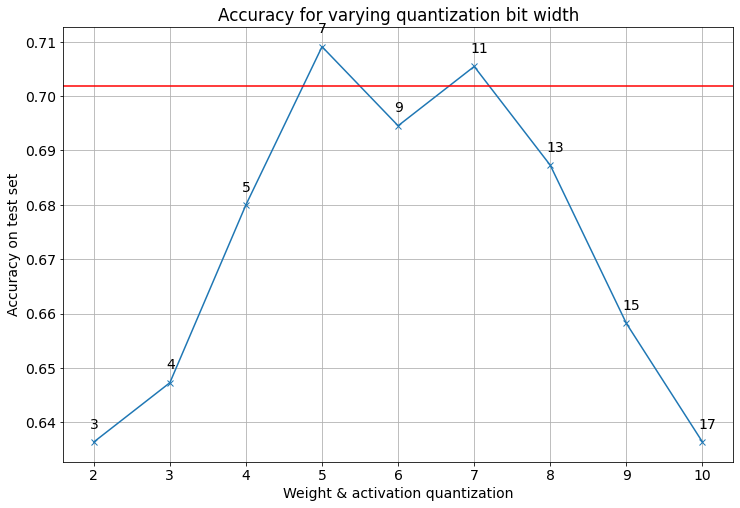

In [152]:
%matplotlib inline

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 8))
plt.rcParams["font.size"] = 14
plt.plot(bit_range, accs, "-x")
for bits, acc, accum in zip(bit_range, accs, accum_bits):
    plt.gca().annotate(str(accum), (bits - 0.05, acc + 0.0025))
plt.ylabel("Accuracy on test set")
plt.xlabel("Weight & activation quantization")
plt.grid(True)
plt.title("Accuracy for varying quantization bit width")
#add baseline, i.e. accuracy of normal model
plt.axhline(y=test_accuracy, color='r', linestyle='-')
plt.show()

It seems that actually, using fhe with n_bits=5 gives quite okay accuracy
(by some coincidence even better than the standard model)
So, we conclude that with the right parameter, we can use the fhe circuit of the logistic regression!

In [153]:
best_possible_bits = 5
fhe_logreg = ConcreteLogisticRegression(n_bits=best_possible_bits)
fhe_logreg.fit(npX, npy)
fhe_logreg.compile(npX, use_virtual_lib=False)

In [157]:
#will most likely take ages!!
test_range = 6
fhe_pred = fhe_logreg.predict(npX[0:test_range], execute_in_fhe=True)

In [160]:
print(fhe_pred, npy[0:len(fhe_pred)])
fhe_correct = np.sum(fhe_pred == npy[0:len(fhe_pred)])
print(fhe_correct, "out of", len(fhe_pred))
print(fhe_correct/len(fhe_pred))


[0 0 0 0 0 0] [0 0 0 0 0 0]
6 out of 6
1.0
